In [47]:
%run ./src/Modules.ipynb  
measureDuration = 3
measureDuration = previousPowerOf2(int(min(10, measureDuration)* 125e6 / 16384)) * 16384 / 125e6
sampleName = 'test'
Rcircuit = 1

In [48]:
RloadArr = []
VmeanArr = []
PmeanArr = []
MaxPressArr = []


while x != 'done':
    inP = ''
    while inP.replace('e', '').isdigit() == False and inP != 'done':
        inP = input('Load resistance [Ohms]')
        if inP.replace('e', '').isdigit() == False and inP != 'done':
            print('Please use the following format: 100 or 1e2')
    if inP == 'done': break
    Rload = float(inP)
    
    # Perform measurements
    # Update the folder with the date/time of the experiment
    folder              = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

    voltage, pressure   = getRFInputs(measureDuration)                                          # Get data from RedPitaya
    pressure.y          /= 2     
    power               = data( voltage.t, voltage.y ** 2 / ( Rload + Rcircuit ))                                                                # Convert from V to Bar


    MaxPressArr.append(np.max(pressure.y))
    RloadArr.append(Rload)
    VmeanArr.append(np.mean(abs(voltage.y)))
    PmeanArr.append(np.mean(abs(power.y)))

    

Please use the following format: 100 or 1e2


Pressure variance: 3.9062499999998334e-07


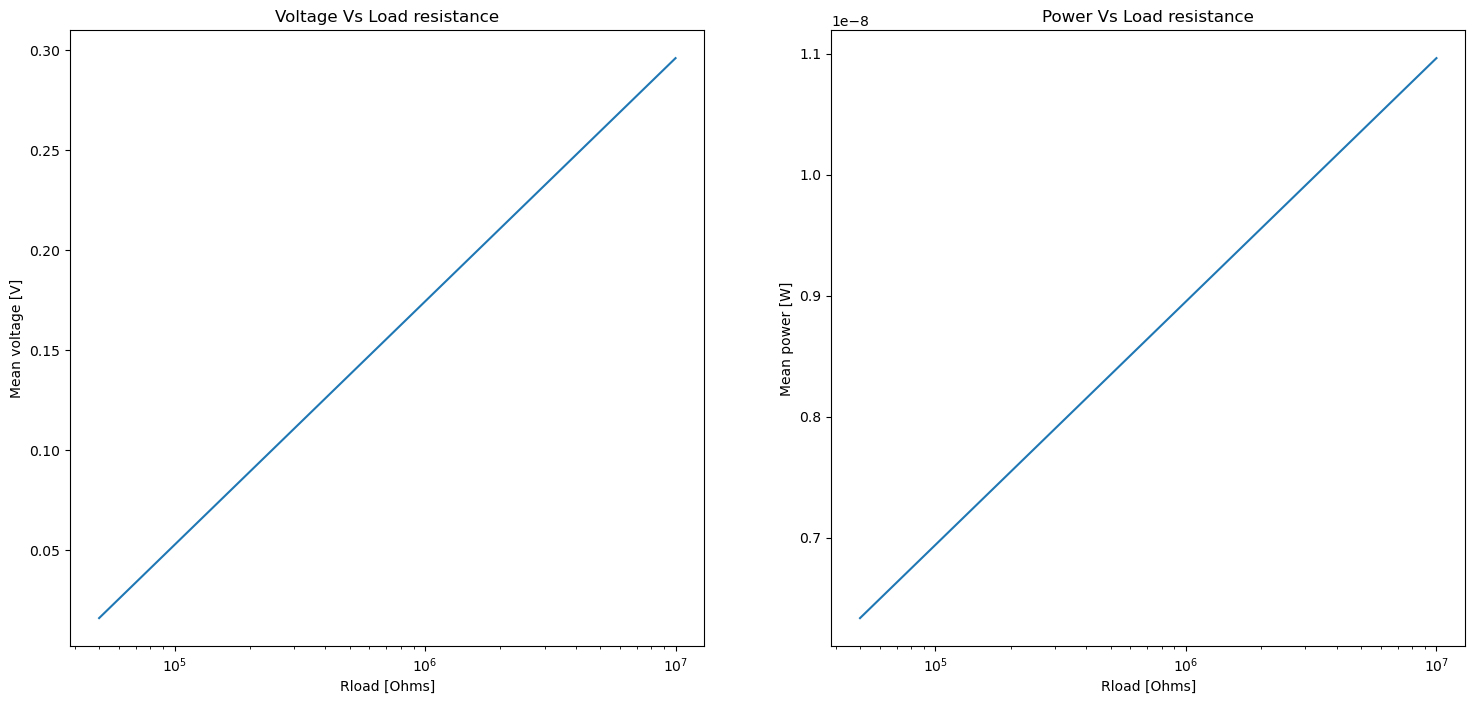

In [49]:
VmeanData = graph(RloadArr, VmeanArr, 'Rload [Ohms]', 'Mean voltage [V]', 'Voltage Vs Load resistance')
PmeanData = graph(RloadArr, PmeanArr, 'Rload [Ohms]', 'Mean power [W]', 'Power Vs Load resistance')
print('Pressure variance: '+str(np.var(MaxPressArr)))
plotGraph([VmeanData], [PmeanData], log=True)